# KNN Best K Analysis

### Load dataset for KNN classification

In this step we:
1. Import all necessary libraries for data handling, visualization, and evaluation.
2. Import our custom function `load_dataset` from the `Data.data_preparation` module.
3. Load the dataset and split it into training and test sets.
4. Print the shapes of the training and test sets, as well as the distribution of labels.

In [29]:
# Import core libraries
import numpy as np
import matplotlib.pyplot as plt

# Import scikit-learn modules for KNN, evaluation metrics, and scaling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, confusion_matrix, classification_report

# Import our custom dataset preparation function
from Data.data_preparation import load_dataset

# Load dataset (features and labels already preprocessed inside load_dataset)
# Returns: training features, training labels, test features, test labels
training, trainingLabels, test, testLabels = load_dataset("Data/WinLoseDataset.csv")

# Show dataset shapes and label distribution for sanity check
print(training.shape, test.shape)
print(trainingLabels.value_counts(), "\n", testLabels.value_counts())

(96, 11) (24, 11)
Ganaste o Perdiste la partida
1    54
0    42
Name: count, dtype: int64 
 Ganaste o Perdiste la partida
1    14
0    10
Name: count, dtype: int64


### Test different values of *k* and distance metrics for KNN

- Define a range of odd `k` values (from 3 to 41) to avoid ties.  
- Test three distance metrics: Euclidean, Manhattan, and Cosine.  
- For each combination of `k` and metric:
  - Train a KNN classifier with distance weighting.  
  - Evaluate it on the test set.  
  - Store precision results.  
- Print the best `k` for each metric and identify the overall best metric + `k`.

In [ ]:
# Define range of k values (odd numbers between 3 and 41)
k_values = list(range(3, 42, 2))

# Distance metrics to evaluate
metrics = ["euclidean", "manhattan", "cosine"]

# Dictionary to hold results per metric
results_by_metric = {}

# Loop over distance metrics
for metric in metrics:
    prec_by_k = {}  # store precision for each k

    # Loop over k values
    for k in k_values:
        # Initialize KNN with given k and metric, using distance weighting
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights="uniform")

        # Train the model on training set
        knn.fit(training, trainingLabels)

        # Predict on test set
        preds = knn.predict(test)

        # Compute precision (positive class = 1, "Win")
        prec = precision_score(testLabels, preds, pos_label=1, zero_division=0) * 100.0

        # Store precision for this k
        prec_by_k[k] = prec

    # Find best k for this metric (by precision)
    best_k = max(prec_by_k, key=prec_by_k.get)
    best_prec = prec_by_k[best_k]

    # Save results for this metric
    results_by_metric[metric] = {"precisions": prec_by_k, "best_k": best_k, "best_prec": best_prec}

    # Print best k for current metric
    print(f"Metric: {metric:9s} | Best k: {best_k:2d} | Precision: {best_prec:.2f}%")

# Identify the overall best metric based on precision
best_metric = max(results_by_metric, key=lambda m: results_by_metric[m]["best_prec"])
best_k = results_by_metric[best_metric]["best_k"]
best_prec = results_by_metric[best_metric]["best_prec"]

print(f"\n>>> Best metric: {best_metric} | Best k: {best_k} | Precision: {best_prec:.2f}%")

Metric: euclidean | Best k:  7 | Precision: 75.00%
Metric: manhattan | Best k: 11 | Precision: 69.23%
Metric: cosine    | Best k: 17 | Precision: 72.73%

>>> Best metric: euclidean | Best k: 7 | Precision: 75.00%


### Train and evaluate the best KNN model

- Initialize KNN with the best hyperparameters (`best_k`, `best_metric`) found earlier.  
- Train it on the scaled training set.  
- Predict labels on the test set.  
- Report:
  - Precision  
  - Classification report (precision, recall, F1-score per class)  
  - Confusion matrix (with labels 0 = "Lose", 1 = "Win").

In [31]:
# Initialize KNN with best hyperparameters found in the previous step
knn_best = KNeighborsClassifier(
    n_neighbors=best_k, 
    metric=best_metric, 
    weights="distance"
)

# Train KNN on the training data
knn_best.fit(training, trainingLabels)

# Predict labels for the test set
preds_best = knn_best.predict(test)

# Print overall accuracy of the best KNN model
print("Precision:", round(precision_score(testLabels, preds_best), 3))

# Print a detailed classification report
# Includes precision, recall, and F1-score for each class
print("\nClassification report:\n", classification_report(testLabels, preds_best, digits=3))

# Compute confusion matrix
# Rows = true labels, Columns = predicted labels
cm = confusion_matrix(testLabels, preds_best, labels=[0, 1])
print("Confusion matrix [rows=true, cols=pred] (0,1):\n", cm)

Precision: 0.75

Classification report:
               precision    recall  f1-score   support

           0      0.583     0.700     0.636        10
           1      0.750     0.643     0.692        14

    accuracy                          0.667        24
   macro avg      0.667     0.671     0.664        24
weighted avg      0.681     0.667     0.669        24

Confusion matrix [rows=true, cols=pred] (0,1):
 [[7 3]
 [5 9]]


### Plot accuracy vs. k for different distance metrics

- Create a line plot of accuracy values for each tested distance metric.  
- For each metric, plot accuracy against the k values.  
- Highlight the best k per metric in the legend.  
- Add grid lines, axis labels, and title for better readability.

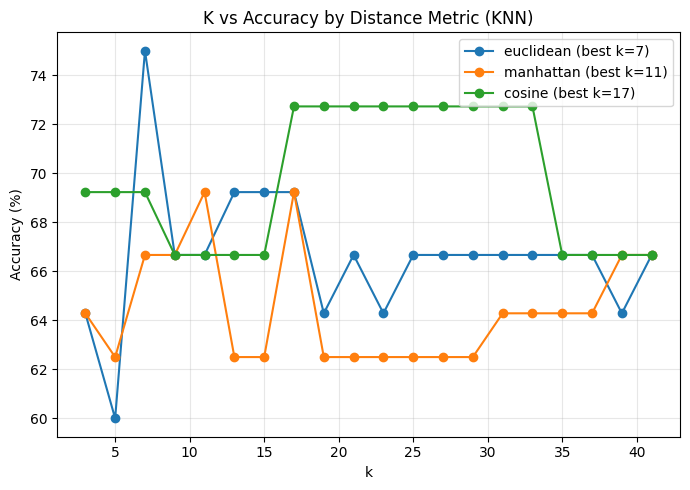

In [33]:
# Create a new figure with defined size
plt.figure(figsize=(7, 5))

# Loop through the results and plot accuracy vs k for each distance metric
for metric, res in results_by_metric.items():
    ks = sorted(res["precisions"].keys())          # all k values tested
    accs = [res["precisions"][k] for k in ks]      # corresponding precisions
    plt.plot(ks, accs, marker='o', label=f"{metric} (best k={res['best_k']})")

# Add plot title and labels
plt.title("K vs Accuracy by Distance Metric (KNN)")
plt.xlabel("k")
plt.ylabel("Accuracy (%)")

# Add legend and grid for readability
plt.legend()
plt.grid(True, alpha=0.3)

# Adjust layout to prevent overlapping labels
plt.tight_layout()

# Display the plot
plt.show()